Note for ben - ran this in baot3-env kernel

In [13]:
# pip install these two and any others that error

!pip install xgboost
!pip install tqdm

  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)


In [2]:
#imports - we should clean these up as many not needed but is fine for now
from datetime import datetime
import sklearn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.model_selection import train_test_split
import statistics

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


# new imports from GPT
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import tqdm

random_seed = 123

### Load data

Define filepaths, load csv and add a column at the end of the csv that denotes class

In [14]:
# Output folder for results:
results_folder = r'C:\Users\bw339\OneDrive - University College London\UCL PhD\Random stuff\Clemency boats\results' # make a results folder in you drive and copy the path with '/' at end here

# Access the spreadsheet of features output by the pretrained CNN
training_data_path = r'C:\Users\bw339\OneDrive - University College London\UCL PhD\Random stuff\Clemency boats\results\features_22.10.09.csv'  # <---- PASTE HERE

# load the data and add new column
df = pd.read_csv(training_data_path, index_col = 0) 
df['boat'] = df.second.apply(lambda x: x[0]) 

# map 'y' to 1 and 'n' to 0
df['boat'] = df['boat'].map({'y': 1, 'n': 0})

df

,second,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,boat
0,n_CCC_106.file.20220628_144100.sec.14410096.wav,0.057379,0.0,1.000599,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.277828,0.006985,0.000000,0.148550,0.000000,0.0,0.0,0.000000,0.000000,0
1,n_CCC_106.file.20220628_144100.sec.14410192.wav,0.000000,0.0,1.000136,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.078738,0.163147,0.000000,0.000000,0.106414,0.0,0.0,0.000000,0.000000,0
2,n_CCC_106.file.20220628_144100.sec.14410288.wav,0.066194,0.0,1.112095,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.139029,0.206391,0.000000,0.059314,0.131425,0.0,0.0,0.000000,0.000000,0
3,n_CCC_106.file.20220628_144100.sec.14410384.wav,0.062848,0.0,0.765249,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.224861,0.026896,0.000000,0.139983,0.190585,0.0,0.0,0.000000,0.000000,0
4,n_CCC_106.file.20220628_144100.sec.14410480.wav,0.012686,0.0,0.988946,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.416637,0.085595,0.000000,0.167281,0.083290,0.0,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11248,y_TCM_1196.file.20220528_191700.sec.19170000.wav,0.000000,0.0,0.184469,0.0,0.0,0.0,0.0,0.062243,0.0,...,0.151773,0.000000,0.082177,0.107255,0.000000,0.0,0.0,0.134394,0.000000,1
11249,y_TCM_1196.file.20220528_191700.sec.19170096.wav,0.000000,0.0,0.056156,0.0,0.0,0.0,0.0,0.207415,0.0,...,0.505443,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.052736,0.000000,1
11250,y_TCM_1196.file.20220528_191700.sec.19170192.wav,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.151056,0.0,...,0.111201,0.000000,0.236746,0.000000,0.000000,0.0,0.0,0.160240,0.161666,1
11251,y_TCM_1196.file.20220528_191700.sec.19170288.wav,0.000000,0.0,0.180817,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.485267,0.000000,0.068282,0.169057,0.000000,0.0,0.0,0.051187,0.009219,1


# XGBOOST

In [4]:
# this cell makes a mini df 'df1' so you can test the code works all the way through. When you're happy with it, 
    # delete this cell, change the 'df1's marked in the cell below to 'df' and run again. Might take a few hours to train.

# take rows 1-5, 100-105, 200-205, 300-305, 400-405 from df and save in df1
df1 = df.iloc[np.r_[1:5, 100:105, 200:205, 300:305, 400:405, 500:505, 600:605, 700:705, 800:805, 900:905, 1000:1005], :]

#now add rows 9000-9005, 9100-9105, 10000-1005, 11000-11005, 12000-12005
df1 = df1.append(df.iloc[np.r_[9000:9005, 9100:9105,9200:9205, 10000:10005, 11000:11005], :])

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, auc, precision_recall_curve
from tqdm import tqdm

# Convert dataframe to numpy arrays
features = df.iloc[:, 1:-1].to_numpy()
labels = df.iloc[:, -1].to_numpy()

# Create groups based on unique IDs
groups = [id.split(".")[0] for id in df['second']]

logo = LeaveOneGroupOut()

# Create an XGBoost classifier
model = XGBClassifier()

# Define hyperparameters for grid search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

# Define variables to track best AUC-PRC score and corresponding hyperparameters
best_auc_prc = 0.0
best_params = {}

# Perform grid search with cross-validation
for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            # Set hyperparameters for the model
            model.set_params(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

            # Define empty lists for storing results
            all_predictions = []
            all_test_labels = []
            all_y_scores = []

            # Perform leave one group out cross-validation
            for train_index, test_index in tqdm(logo.split(features, labels, groups), total=logo.get_n_splits(groups=groups), desc="LOGO CV"):
                # Split data
                train_features, test_features = features[train_index], features[test_index]
                train_labels, test_labels = labels[train_index], labels[test_index]

                # Fit model
                model.fit(train_features, train_labels)

                # Make predictions
                predictions = model.predict(test_features)
                y_scores = model.predict_proba(test_features)[:, 1]
                y_pred_thresholded = (y_scores > 0.5).astype(int)  # Adjust the threshold here

                # Save predictions, test labels, and scores
                all_predictions.extend(y_pred_thresholded)
                all_test_labels.extend(test_labels)
                all_y_scores.extend(y_scores)

            # Calculate AUC-PRC for the current parameter combination
            prc_precision, prc_recall, _ = precision_recall_curve(all_test_labels, all_y_scores)
            auc_prc = auc(prc_recall, prc_precision)

            # Update best AUC-PRC score and corresponding hyperparameters if necessary
            if auc_prc > best_auc_prc:
                best_auc_prc = auc_prc
                best_params = {'max_depth': max_depth, 'learning_rate': learning_rate, 'n_estimators': n_estimators}

# Get the best model using the best hyperparameters
best_model = XGBClassifier(**best_params)

LOGO CV:   0%|          | 0/1217 [00:00<?, ?it/s]

LOGO CV:   0%|          | 2/1217 [00:38<6:27:09, 19.12s/it]


KeyboardInterrupt: 

In [ ]:
# Print the best hyperparameters and the corresponding performance metrics
print("Best Hyperparameters:")

for param, value in best_params.items():
    print(f"{param}: {value}")

Best Hyperparameters:
max_depth: 3
learning_rate: 0.01
n_estimators: 300


In [ ]:
# Perform leave one group out cross-validation with the best model
for train_index, test_index in logo.split(features, labels, groups):
    # Split data
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Fit best model
    best_model.fit(train_features, train_labels)
   
    # Make predictions
    predictions = best_model.predict(test_features)
    y_scores = best_model.predict_proba(test_features)[:, 1]
    y_pred_thresholded = (y_scores > 0.5).astype(int)  # Adjust the threshold here

    # Save predictions, test labels, and scores
    all_predictions.extend(y_pred_thresholded)
    all_test_labels.extend(test_labels)
    all_y_scores.extend(y_scores)

# After the loop, calculate the performance metrics
accuracy = accuracy_score(all_test_labels, all_predictions)
precision, recall, _, _ = precision_recall_fscore_support(all_test_labels, all_predictions, average='binary')
tn, fp, fn, tp = confusion_matrix(all_test_labels, all_predictions).ravel()

# Compute AUC-PRC and plot the precision-recall curve
prc_precision, prc_recall, _ = precision_recall_curve(all_test_labels, all_y_scores)
auc_prc = auc(prc_recall, prc_precision)

Accuracy: 0.8227848101265823
Precision: 0.7340425531914894
Recall: 0.69
TN: 191
FP: 25
FN: 31
TP: 69
AUC-PRC: 0.8417146855578307


# Evaluating performance

In [ ]:
# Print key metrics
print('Cross-validated accuracy: %.3f%%' % (accuracy*100))
print('Cross-validated precision: %.3f' % precision)
print('Cross-validated recall: %.3f' % recall)
print('Cross-validated TP: %d' % tp)
print('Cross-validated FP: %d' % fp)
print('Cross-validated FN: %d' % fn)
print('Cross-validated TN: %d' % tn)
print('Cross-validated AUC-PRC: %.3f' % auc_prc)

Cross-validated accuracy: 82.278%
Cross-validated precision: 0.734
Cross-validated recall: 0.690
Cross-validated TP: 69
Cross-validated FP: 25
Cross-validated FN: 31
Cross-validated TN: 191
Cross-validated AUC-PRC: 0.842


### Plot the precision-recall curve

This curve uses probability values from each iteration the model, i.e what class it predicted for the left out group and how confident it was in this. The cut off probability will currently be 0.5, so if its confidence that a recording is a boat is >0.5 if will be classified as such adn vice versa. If we moved this to 0.8, only recordings for which it is >0.8 will be classified as boat. For most datapoints it will be really confidet one way or the other (<0.1 or >0.9).

This shows how the results would change if we shifted that confidence cutoff. The curve should hug the top right hand corner tightly showing it makes no difference.

One tactic if we think it is still giving lots of fasle positives would be to shift this confidence threshold up. This may miss some boats, but would produce less false positives. As you are comparing boat pressure, rather than total boat pressure (though guess ideally that too?), this could be a solution to remove the need for manual verificiation.

That being said the model I trained was 96% accurate so lets see all these results first!

This curve and all the metrics should probably go in the paper

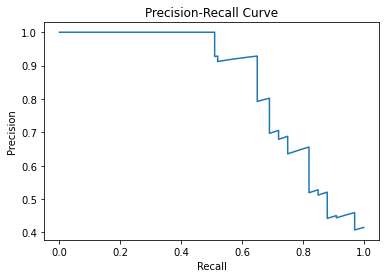

In [ ]:
plt.plot(prc_recall, prc_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### Plot confusion matrix

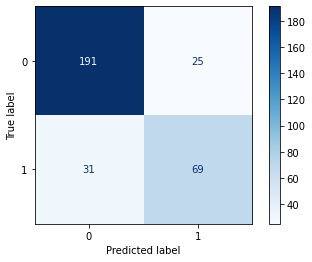

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(all_test_labels, all_predictions)

# Show the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Train a final mode

Now we have done evaluation, we train on the full dataset, rather than using leave one out. We can assume the accuracy will be near identical thanks to the fact we used LOOCV until now.

This cell will run this and save the model to a .pkl file so it can be used again in the future.

In [ ]:
from xgboost import XGBClassifier
import joblib

# Convert dataframe to numpy arrays
features = df.iloc[:, 1:-1].to_numpy()
labels = df.iloc[:, -1].to_numpy()

# Create an XGBoost classifier
model = XGBClassifier()

# Fit the model on the whole dataset
model.fit(features, labels)

# Save the model to a file in the results folder
model_path = results_folder + r'\xgb_model_gridsearched.pkl'
joblib.dump(model, model_path)

['C:\\Users\\bw339\\OneDrive - University College London\\UCL PhD\\Random stuff\\Clemency boats\\results\\xgb_model.pkl']

### Load model
 We load the saved model form the .pkl and inference on the full dataset. 
 
 There will be no need to rerun the training again and actually all the below code should maybe be moved into a separate script (just add any imports that are missing with 'no module found errors' and add the results_folder variable at the top etc)

 You can then do this one by one on the csv from the full dataset. Be sure you can keep track of which is which or change the '/new_data_predictions_' part in the very last cell to a name that means something to you for each

In [48]:
# Load the saved model
loaded_model = joblib.load(results_folder+'/xgb_model.pkl')

In [50]:
# load features from the full dataset (or subset of this if split into spreadsheets of e.g site)
new_data_path = r'' # <--- paste the path to your csv file here (if you want to test this just make it new_data_path = training_data_path)

new_data_df = pd.read_csv(new_data_path, index_col = 0) #load dataframe
new_data_predictions = loaded_model.predict(new_data_df.iloc[:, 1:].to_numpy()) # predict

new_data_predictions_df = pd.DataFrame(new_data_df['second'])
new_data_predictions_df.insert(1, 'Boat y or n', new_data_predictions) #add the column

new_data_predictions_df

,second,Boat y or n
0,n_CCC_106.file.20220628_144100.sec.14410096.wav,0
1,n_CCC_106.file.20220628_144100.sec.14410192.wav,0
2,n_CCC_106.file.20220628_144100.sec.14410288.wav,0
3,n_CCC_106.file.20220628_144100.sec.14410384.wav,0
4,n_CCC_106.file.20220628_144100.sec.14410480.wav,0
...,...,...
11248,y_TCM_1196.file.20220528_191700.sec.19170000.wav,0
11249,y_TCM_1196.file.20220528_191700.sec.19170096.wav,0
11250,y_TCM_1196.file.20220528_191700.sec.19170192.wav,0
11251,y_TCM_1196.file.20220528_191700.sec.19170288.wav,0


In [51]:
# export to a csv saved in your 'results_folder' specified earlier ^
now = datetime.now()
time_now = now.strftime("%H.%M.%S")
new_data_predictions_df.to_csv(results_folder + '/new_data_predictions_' + time_now + '.csv')